In [17]:
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel, ViTConfig
from maskgen.utils.img_utils import plot_overlap_np
from torch.utils.data import DataLoader
import torch
import json
import os
from tqdm import tqdm
import numpy as np
from typing import Dict, Any

config = {
        "pretrained_name": "google/vit-base-patch16-224",
        "results_path": "/scratch365/dpan/new_results/gradcam",
        "max_samples": 100,
        "dataset_split": "tiny",
        "num_samples": 1000,
        "batch_size":1,
}

In [18]:
from maskgen.utils.model_utils import get_pred_model

# Create results directory if it doesn't exist
if not os.path.exists(config['results_path']):
    os.makedirs(config['results_path'])

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models and processor
pretrained_name = config['pretrained_name']
processor, target_model = get_pred_model(pretrained_name, device)

print("target model loaded")

target model loaded


In [19]:
from baselines.ViT.ViT_new import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import Baselines
from samples.CLS2IDX import CLS2IDX

# initialize ViT pretrained
model = vit_LRP(pretrained=True).cuda()
model.eval()
attribution_generator = Baselines(model)



In [31]:
from maskgen.utils.image_utils import get_image_example
from maskgen.utils.model_utils import get_pred_model


processor, target_model = get_pred_model(pretrained_name, device)
image = get_image_example(9)
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values.to(device)

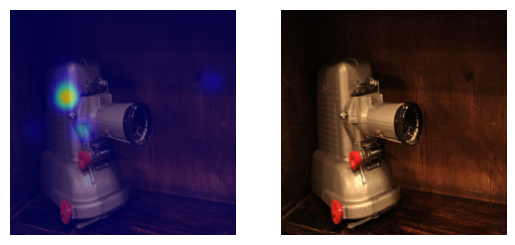

In [32]:

def get_heatmap(attribution_attvis):
    # heatmap = torch.relu(attribution_ig.sum(dim=1))
    heatmap = attribution_attvis.reshape(1, 14, 14)
    # Average pooling to convert to 14*14 heatmap
    # heatmap = F.avg_pool2d(heatmap, kernel_size=16, stride=16)
    heatmap = heatmap.squeeze(0).detach().cpu().numpy()
    return heatmap

img = inputs['pixel_values'].squeeze(0).detach().cpu().numpy().transpose(1,2,0)
# img = unnormalize_and_255_scale(img, mean, std)
input_img = inputs['pixel_values']
# for idx in range(1000):
#     attribution_attvis = attribution_generator.generate_cam_attn(input_img.cuda()).detach()
attribution_cam = attribution_generator.generate_cam_attn(input_img.cuda()).detach()
heatmap = get_heatmap(attribution_cam)

img_int, heatmap_img = plot_overlap_np(img, heatmap, processor.image_mean, processor.image_std)

# Batch evaluation

In [33]:
from maskgen.utils.img_utils import plot_overlap_np
from maskgen.utils.data_utils import get_imagenet_dataloader

# get dataloader
dataloader = get_imagenet_dataloader(split='tiny', 
                                    batch_size=config['batch_size'], 
                                    processor=processor, 
                                    shuffle=False,
                                    num_samples=config['num_samples'])

Repo card metadata block was not found. Setting CardData to empty.


In [34]:
all_inputs = []
all_heatmaps = []

for i, batch in tqdm(enumerate(dataloader), total=len(dataloader), desc="Processing batches"):
    pixel_values = batch['pixel_values'].to(device)
    labels = batch['labels'].to(device)
    attribution_cam = attribution_generator.generate_cam_attn(pixel_values.cuda()).detach()
    attribution_map = get_heatmap(attribution_cam)

    inputs_np = pixel_values.cpu().numpy()
    # unsqueeze the first dimension for numpy
    heatmap_np = attribution_map.reshape(1, 14, 14)
    all_inputs.append(inputs_np)
    all_heatmaps.append(heatmap_np)

all_inputs = np.concatenate(all_inputs, axis=0)
all_heatmaps = np.concatenate(all_heatmaps, axis=0)
    

Processing batches: 100%|██████████| 1000/1000 [00:19<00:00, 51.87it/s]


In [35]:
from maskgen.utils.save_utils import save_pixel_heatmap_pairs

save_path = config['results_path']
if not os.path.exists(save_path):
    os.makedirs(save_path)
save_path = os.path.join(save_path, 'pixel_heatmap_pairs.npz')
save_pixel_heatmap_pairs(all_inputs, all_heatmaps, save_path)